# KERNEL CLEAN

In [1]:
%reset -f -s

import gc

# LIBRARIES IMPORT

In [2]:
# imports

import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
d_type='processed'     # 'processed', 'synthetic'
video_d=True            # Video = True , Image = False 
test_data,number_data_points= False,500

t_btw_frm=0.05

checking_on=False

data_augmentation= True

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/model_checkpoint.h5"

if d_type=='processed' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  
elif d_type=='synthetic' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/synthetic_train_d.pkl'   
     

# CNN

### GENERATE TRAIN DATA

In [4]:
# X_train,Y_train

with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]


### CHECK 1

In [5]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):
        print(r,int(y),np.shape(x),type(x))

In [6]:
if checking_on:

    rec_elm='I70'
    idx=rcs.index(rec_elm)
    print(y_train[idx])

In [7]:
if checking_on:fig_lib.vid_show(x_train[idx],t_btw_frm=t_btw_frm)

In [8]:
if test_data:

    total_data_points=len(y_train)
    test_len=total_data_points-number_data_points
    
    Xx_train=x_train[0:number_data_points]
    Yy_train=y_train[0:number_data_points]
    rcs=rcs[0:number_data_points]

else:

    Xx_train=x_train
    Yy_train=y_train


## DATA SHUFFLE 1

In [9]:
Xx_train,Yy_train,recs=CNN_lib.shuffle(Xx_train,Yy_train,rcs)

### CHECK 2

In [10]:
if checking_on:

    for x,y,r in zip(Xx_train,Yy_train,recs):
        print(r,int(y),np.shape(x),type(x))

In [11]:
if checking_on:

    rec_elm='I54'
    idx=recs.index(rec_elm)
    print(idx,Yy_train[idx])

In [12]:
if checking_on:fig_lib.vid_show(Xx_train[idx],t_btw_frm=t_btw_frm)

### DATA SPLIT

In [13]:
test_size=0.2

X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl = train_test_split(Xx_train, Yy_train, test_size=test_size, shuffle=False) #,random_state=42)

recs_train =recs[0:len(Y_train_spl)]
recs_eval =recs[len(Y_train_spl)::]

print('Train data:',len(Y_train_spl),'Evaluation data:',len(Y_eval_spl))

if test_data:print('Test_len:',test_len)

Train data: 528 Evaluation data: 132


In [14]:
if checking_on:

    rec_elm='I921'
    idx=recs_train.index(rec_elm)
    print(idx,Y_train_spl[idx])


In [15]:
if checking_on:fig_lib.vid_show(X_train_spl[idx],t_btw_frm=t_btw_frm)

 Train data shape: (528, 40, 160, 160, 1)  Validation data shape: (132, 40, 160, 160, 1)


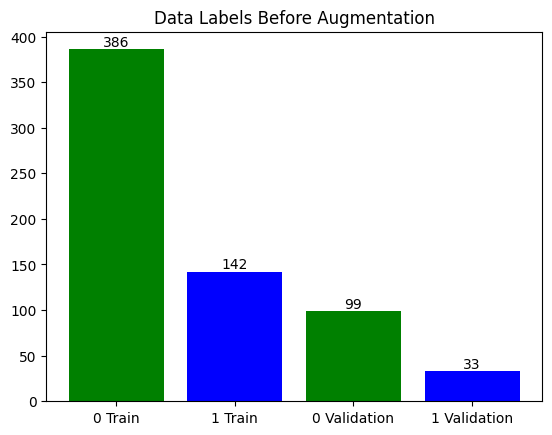

In [16]:
# check data

zeros_count = np.sum(Y_train_spl == 0)
ones_count = np.sum(Y_train_spl == 1)
zeros_count_val = np.sum(Y_eval_spl == 0)
ones_count_val = np.sum(Y_eval_spl == 1)

print(' Train data shape:', np.shape(X_train_spl),' Validation data shape:', np.shape(X_eval_spl))

CNN_lib.data_bars_plot(zeros_count,ones_count,zeros_count_val,ones_count_val)

# DATA AUGMENTATION

In [17]:
if data_augmentation:
    
    n_flip_1=1
    n_flip_0=0.07

    nf1 = round(n_flip_1*ones_count)
    nf0 = round(n_flip_0*zeros_count)

    print(f'Flip 1: {nf1}, 0: {nf0}')

    n_contr_1=0.3
    n_contr_0=0.03

    nc1 = round(n_contr_1*ones_count)
    nc0 = round(n_contr_0*zeros_count)

    print(f'Contrast 1: {nc1}, 0: {nc0}')

    n_bright_1=0.3
    n_bright_0=0.03

    nb1 = round(n_bright_1*ones_count)
    nb0 = round(n_bright_0*zeros_count)

    print(f'brightness 1: {nb1}, 0: {nb0}')



Flip 1: 142, 0: 27
Contrast 1: 43, 0: 12
brightness 1: 43, 0: 12


In [18]:

if data_augmentation:

    Flip_X_1,Flip_Y_1,Flip_recs_1=CNN_lib.main_aug_f(nf1,X_train_spl,Y_train_spl,recs,label=1,typ='Flip')
    Flip_X_0,Flip_Y_0,Flip_recs_0=CNN_lib.main_aug_f(nf0,X_train_spl,Y_train_spl,recs,label=0,typ='Flip')

    Cntr_X_1,Cntr_Y_1,Cntr_recs_1=CNN_lib.main_aug_f(nc1,X_train_spl,Y_train_spl,recs,label=1,typ='Contrast')
    Cntr_X_0,Cntr_Y_0,Cntr_recs_0=CNN_lib.main_aug_f(nc0,X_train_spl,Y_train_spl,recs,label=0,typ='Contrast')

    Bgr_X_1,Bgr_Y_1,Bgr_recs_1=CNN_lib.main_aug_f(nb1,X_train_spl,Y_train_spl,recs,label=1,typ='Brightness')
    Bgr_X_0,Bgr_Y_0,Bgr_recs_0=CNN_lib.main_aug_f(nb0,X_train_spl,Y_train_spl,recs,label=0,typ='Brightness')


In [19]:
if data_augmentation:

    X_train_spl = np.concatenate((X_train_spl, Flip_X_1,Flip_X_0,Cntr_X_1,Cntr_X_0,Bgr_X_1,Bgr_X_0), axis=0)
    Y_train_spl = np.concatenate((Y_train_spl, Flip_Y_1, Flip_Y_0,Cntr_Y_1,Cntr_Y_0,Bgr_Y_1,Bgr_Y_0))
    
    recs_train = recs_train+Flip_recs_1+Flip_recs_0+Cntr_recs_1+Cntr_recs_0+Bgr_recs_1+Bgr_recs_0

    print(X_train_spl.shape,Y_train_spl.shape)
    print(X_eval_spl.shape,Y_eval_spl.shape)


(807, 40, 160, 160, 1) (807,)
(132, 40, 160, 160, 1) (132,)


### DATA SHUFFLE 2

In [20]:
if data_augmentation: X_train,Y_train,recs_train_f=CNN_lib.shuffle(X_train_spl,Y_train_spl,recs_train)
else: X_train,Y_train,recs_train_f = X_train_spl,Y_train_spl,recs_train

X_eval=X_eval_spl
Y_eval=Y_eval_spl

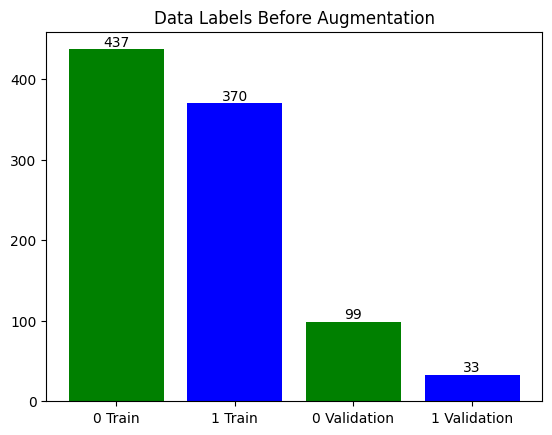

In [21]:
# check data
if data_augmentation:

    zeros_count = np.sum(Y_train == 0)
    ones_count = np.sum(Y_train == 1)
    zeros_count_val = np.sum(Y_eval == 0)
    ones_count_val = np.sum(Y_eval == 1)

    CNN_lib.data_bars_plot(zeros_count,ones_count,zeros_count_val,ones_count_val)

### CHECK 3

In [22]:
if checking_on:

    for x,y,r in zip(X_train,Y_train,recs_train_f):
        print(r,int(y),np.shape(x),type(x))
        

In [23]:

if checking_on:

    rec_elm='I180'
    idx=recs_train_f.index(rec_elm)
    print(idx,Y_train[idx])

In [24]:
if checking_on:fig_lib.vid_show(X_train[idx],t_btw_frm=t_btw_frm)

#  CNN

In [25]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D
conv3D_2D+1


In [26]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epochs=9


### MODEL

In [27]:
gc.collect()

5893

In [28]:
# MODEL 

if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, HEIGHT, WIDTH, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(HEIGHT, WIDTH,1))

else:

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(3, 3, 1), activation='relu',input_shape=(max_frm_n, HEIGHT, WIDTH, 1)),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 1),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 1),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=16, kernel_size=(1, 1, 5),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 38, 158, 160, 16   160       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 19, 79, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 17, 77, 80, 32)    4640      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 8, 38, 40, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 36, 40, 32)     9248      
                                                       

In [29]:
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

In [30]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',   mode='min', verbose=1)

### TRAINNING

In [31]:
history =model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_eval,Y_eval),callbacks=[checkpoint])

Epoch 1/9


26/26 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5700
Epoch 1: val_loss improved from inf to 0.71782, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
26/26 [==============================] - 14s 509ms/step - loss: 0.6879 - accuracy: 0.5700 - val_loss: 0.7178 - val_accuracy: 0.4697
Epoch 2/9


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6245
Epoch 2: val_loss improved from 0.71782 to 0.65170, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
26/26 [==============================] - 13s 507ms/step - loss: 0.6437 - accuracy: 0.6245 - val_loss: 0.6517 - val_accuracy: 0.5985
Epoch 3/9
26/26 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.7051
Epoch 3: val_loss improved from 0.65170 to 0.55202, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
26/26 [==============================] - 13s 510ms/step - loss: 0.5837 - accuracy: 0.7051 - val_loss: 0.5520 - val_accuracy: 0.7348
Epoch 4/9
26/26 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.7385
Epoch 4: val_loss improved from 0.55202 to 0.55158, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_M

### EVALUATE MODEL

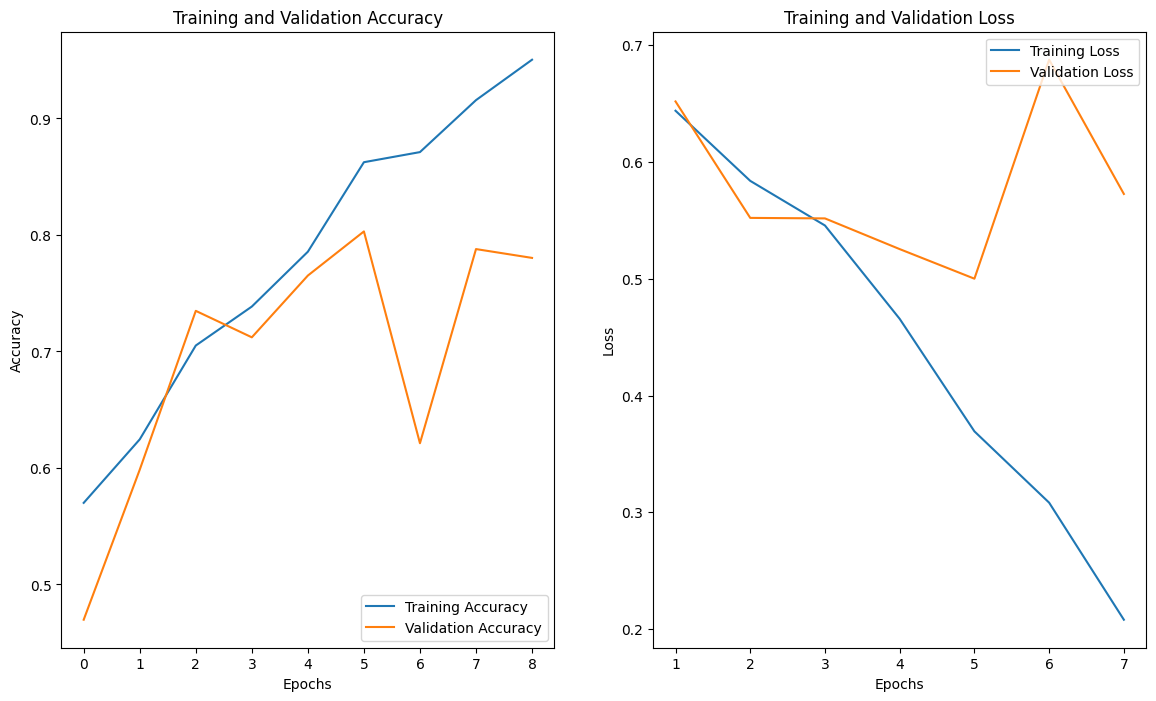

In [32]:
CNN_lib.plot_train_eval(history,epochs)

In [33]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

5/5 - 1s - loss: 0.6273 - accuracy: 0.7803 - 584ms/epoch - 117ms/step
Loss: 0.6272915601730347 Accuracy: 0.7803030014038086


### BEST EPOCH

In [34]:
model = load_model(checkpoint_path)
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)
print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

5/5 - 1s - loss: 0.5000 - accuracy: 0.8030 - 652ms/epoch - 130ms/step
Loss: 0.4999937117099762 Accuracy: 0.8030303120613098


In [35]:
performance_d={'NAME':mdl,
               'ACCURACY':test_accuracy,
               'LOSS':test_loss,
               'HEIGHT':HEIGHT,
               'WIDTH':WIDTH}

performance_d

{'NAME': 'video_conv3D',
 'ACCURACY': 0.8030303120613098,
 'LOSS': 0.4999937117099762,
 'HEIGHT': 160,
 'WIDTH': 160}

# VALIDATION DATA

In [36]:
predictions = model.predict(X_eval)
#print(predictions)


5/5 [==============================] - 1s 104ms/step


## ROC CURVE

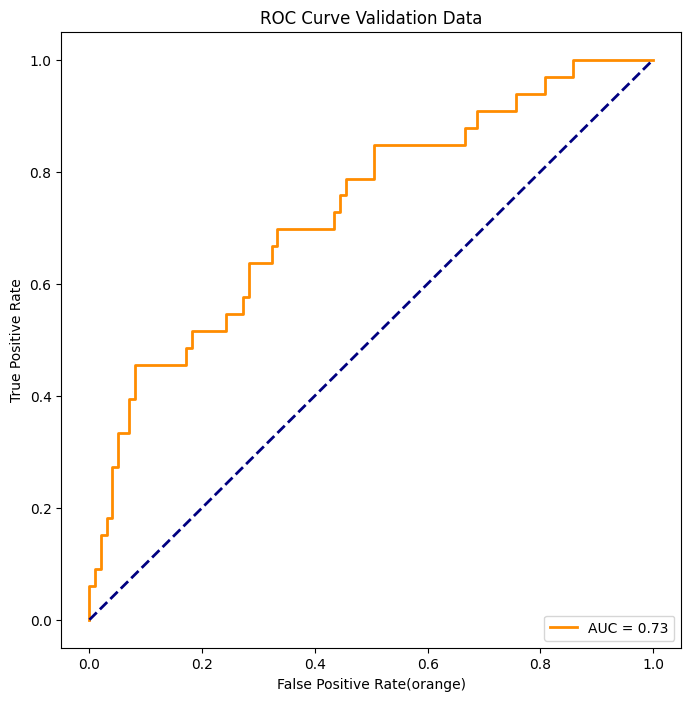

In [37]:
fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)
roc_auc_false = auc(fpr_val, tpr_val)

CNN_lib.plot_roc_curve(fpr_val,tpr_val,roc_auc_false)

In [38]:


"""plt.figure(figsize=(8, 8))

plt.plot(thresholds_val,tpr_val, color='darkorange', lw=2, label='TRUE POSSITIVE')
plt.plot(thresholds_val,fpr_val, color='blue', lw=2, label=f'FALSE pOSSITIVE')
plt.xlabel('Threshold (green)')
plt.ylabel('True/Negative Positive Rate')
plt.title('threshold')
plt.legend()
plt.show()"""

"plt.figure(figsize=(8, 8))\n\nplt.plot(thresholds_val,tpr_val, color='darkorange', lw=2, label='TRUE POSSITIVE')\nplt.plot(thresholds_val,fpr_val, color='blue', lw=2, label=f'FALSE pOSSITIVE')\nplt.xlabel('Threshold (green)')\nplt.ylabel('True/Negative Positive Rate')\nplt.title('threshold')\nplt.legend()\nplt.show()"

#  FORECAST EVALUATION

In [39]:
predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [40]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



Matriz de Confusión:
[[76 23]
 [16 17]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        99
           1       0.42      0.52      0.47        33

    accuracy                           0.70       132
   macro avg       0.63      0.64      0.63       132
weighted avg       0.73      0.70      0.71       132



In [41]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [42]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]

print(correct_labels_val)

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


In [43]:

print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')


OK, 93
BAD, 39
Ratio forecast: 2.3846153846153846
Ratio labeling: 3.0


## SINGLE FORECAST

In [44]:

print(recs_eval)


['I646', 'I872', 'I384', '656335_3', 'I801', '660022_2', 'I999', 'I266', '380772_1', '670615_6', 'I1067', 'I899', '656335_5', 'I782', 'I837', 'I93', '385597_17', '673676_8', '224436_7', 'I473', 'I302', 'I542', '660022_7', 'I218', 'I1143', 'I1027', 'I180', '651399_4', '547169_1', '670615_20', 'I1145', '673676_26', 'I200', 'I327', 'I391', 'I1045', '224436_17', '109897_6', 'I1224', 'I1098', 'I1', 'I980', 'I1228', 'I164', '6272_11', 'I39', '178572_8', 'I265', 'I64', 'I1055', 'I381', 'I624', 'I102', 'I803', '178572_1', 'I696', '656335_8', 'I610', 'I1120', 'I1100', 'I1118', 'I51', '670615_8', 'I94', '539258_4', '673676_18', 'I252', 'I996', '646778_8', 'I116', 'I902', '673676_21', 'I439', '6272_5', 'I669', '673676_23', 'I57', '224436_12', '656960_3', '380772_9', '646778_27', 'I968', 'I1272', 'I465', 'I299', 'I1025', 'I914', 'I159', 'I818', 'I213', 'I737', '651399_7', 'I87', 'I1119', '224436_9', 'I986', '6272_6', '224436_16', 'I712', '673676_2', 'I1209', 'I723', 'I215', 'I238', 'I820', 'I1022'

In [45]:

rec_elm='I765'
idx=recs_eval.index(rec_elm)


print(f' Record: {rec_elm} , index: {idx}, real label: {Y_eval_spl[idx]}')

ValueError: 'I765' is not in list

In [ ]:
if checking_on:fig_lib.vid_show(X_eval[idx],t_btw_frm=t_btw_frm)

In [ ]:
nuevo_video = np.expand_dims(X_eval[idx], axis=0)

# Realizar la predicción
prediccion = model.predict(nuevo_video)
prediccion